# Import Libraries

In [602]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline
mpl.rcParams['figure.figsize'] = [18, 10]

# Scrape Data

In [490]:
# problems with yahoo finance - use AlphaVantage API instead

In [621]:
import requests
import json
import pandas as pd
import datetime as dt

timestep = 21
ticker = 'VZ'
interval = '1d'
length_days = '365d'

url = f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}"
params = {'interval': interval, 'range': length_days, 'includePrePost': True}
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0"}
resp = requests.get(url, params=params, headers=headers)
data = resp.json()
time = pd.Series(data['chart']['result'][0]['timestamp'])
close = pd.Series(data['chart']['result'][0]['indicators']['quote'][0]['close'])
df = pd.concat([time, close], axis=1)
df.columns = ['Time', 'Close']
df['Time'] = df['Time'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df = df.set_index('Time')
df.columns = ['Close']

# 1: LSTM 

In [622]:
print("Data shape: ", df.shape)
train_len = int(len(df['Close'])*0.8)
train_len

# 2021 testing set 
df_train = df[0:train_len]
df_test = df[train_len:]
print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)


# Feature Scaling / consider other scalers
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(df_train)
testing_set_scaled = scaler.transform(df_test)

print("Training set scaled: ", training_set_scaled.shape)
print("Testing set scaled: ", testing_set_scaled.shape)

# Creating a data structure with 30 timesteps and 1 output
X_train = []
y_train = []
for i in range(timestep, df_train.shape[0]):
    X_train.append(training_set_scaled[i-timestep:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train reshaped: ", X_train.shape)

Data shape:  (365, 1)
Train data shape:  (292, 1)
Test data shape:  (73, 1)
Training set scaled:  (292, 1)
Testing set scaled:  (73, 1)
X_train shape:  (271, 21)
y_train shape:  (271,)
X_train reshaped:  (271, 21, 1)


In [ ]:
# multi variate 


In [623]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 128))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_151 (LSTM)              (None, 21, 128)           66560     
_________________________________________________________________
dropout_33 (Dropout)         (None, 21, 128)           0         
_________________________________________________________________
lstm_152 (LSTM)              (None, 21, 128)           131584    
_________________________________________________________________
dropout_34 (Dropout)         (None, 21, 128)           0         
_________________________________________________________________
lstm_153 (LSTM)              (None, 21, 128)           131584    
_________________________________________________________________
dropout_35 (Dropout)         (None, 21, 128)           0         
_________________________________________________________________
lstm_154 (LSTM)              (None, 128)             

In [620]:
from sklearn.metrics import r2_score
lstm_score = r2_score(df_test, predicted_stock_price)
lstm_score

-0.13493485567272456

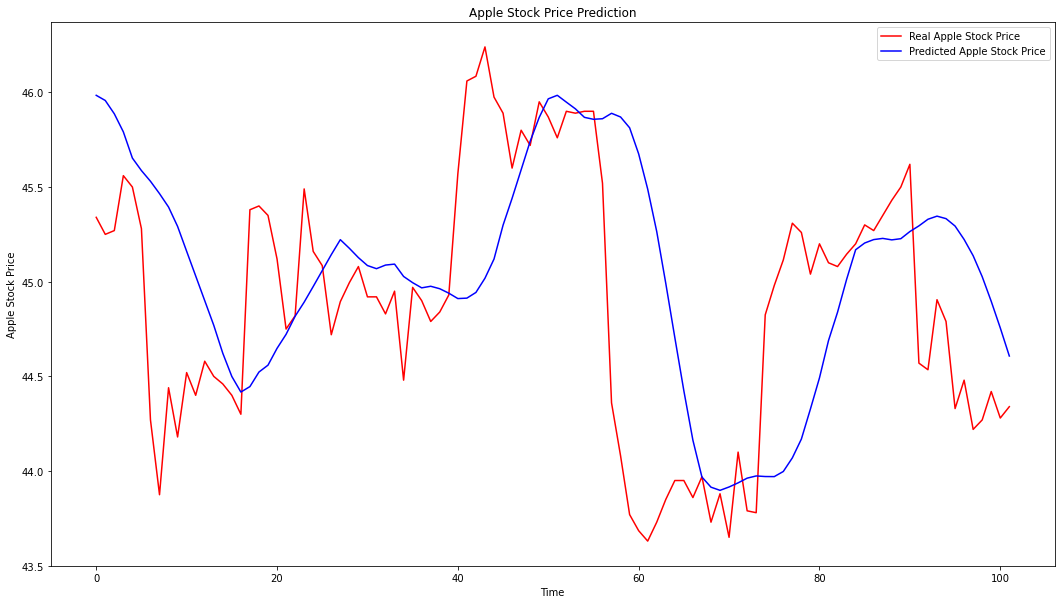

In [616]:
# prediction/visualization
real_stock_price = df_test.iloc[:, 0].values

dataset_total = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_test) - timestep:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(timestep, (df_test.shape[0]+timestep)):
    X_test.append(inputs[i-timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(df_test.values, color = 'red', label = 'Real Apple Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [ ]:
lstm_score = r2_score(tes)

# ARIMA Model

# Facebook Prophet